In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
data_dir = '../hand_gesture_recognition_project/leapGestRecog'  # Thư mục chứa dữ liệu

images = []
labels = []
for directory in os.listdir(data_dir):
    dir_path = os.path.join(data_dir, directory)
    if os.path.isdir(dir_path):
        for subDir in os.listdir(dir_path):
            sub_dir_path = os.path.join(dir_path, subDir)
            if os.path.isdir(sub_dir_path):
                for img in os.listdir(sub_dir_path):
                    img_path = os.path.join(sub_dir_path, img)
                    images.append(img_path)
                    labels.append(subDir)

In [3]:
df = pd.DataFrame({'Images': images, 'labels': labels})
print("Ví dụ dữ liệu:")
print(df.head())

Ví dụ dữ liệu:
                                              Images   labels
0  ../hand_gesture_recognition_project/leapGestRe...  01_palm
1  ../hand_gesture_recognition_project/leapGestRe...  01_palm
2  ../hand_gesture_recognition_project/leapGestRe...  01_palm
3  ../hand_gesture_recognition_project/leapGestRe...  01_palm
4  ../hand_gesture_recognition_project/leapGestRe...  01_palm


In [4]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['labels'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['labels'])

print("\nSố lượng mẫu:")
print("Train: ", len(train_df))
print("Validation: ", len(val_df))
print("Test: ", len(test_df))



Số lượng mẫu:
Train:  14070
Validation:  3015
Test:  3015


In [5]:
batch_size = 32
target_size = (224, 224)

In [6]:
train_generator_custom = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    train_df, x_col="Images", y_col="labels",
    target_size=target_size, class_mode="categorical",
    batch_size=batch_size, shuffle=True
)
val_generator_custom = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    val_df, x_col="Images", y_col="labels",
    target_size=target_size, class_mode="categorical",
    batch_size=batch_size, shuffle=False
)
test_generator_custom = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
    test_df, x_col="Images", y_col="labels",
    target_size=target_size, class_mode="categorical",
    batch_size=batch_size, shuffle=False
)

Found 14000 validated image filenames belonging to 10 classes.


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 70 invalid image filename(s) in x_col="Images". These filename(s) will be ignored.
  warnings.warn(


Found 3000 validated image filenames belonging to 10 classes.


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 15 invalid image filename(s) in x_col="Images". These filename(s) will be ignored.
  warnings.warn(


Found 3000 validated image filenames belonging to 10 classes.


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 15 invalid image filename(s) in x_col="Images". These filename(s) will be ignored.
  warnings.warn(


In [7]:
train_generator_mobilenet = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
).flow_from_dataframe(
    train_df, x_col="Images", y_col="labels",
    target_size=target_size, class_mode="categorical",
    batch_size=batch_size, shuffle=True
)
val_generator_mobilenet = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
).flow_from_dataframe(
    val_df, x_col="Images", y_col="labels",
    target_size=target_size, class_mode="categorical",
    batch_size=batch_size, shuffle=False
)
test_generator_mobilenet = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
).flow_from_dataframe(
    test_df, x_col="Images", y_col="labels",
    target_size=target_size, class_mode="categorical",
    batch_size=batch_size, shuffle=False
)

Found 14000 validated image filenames belonging to 10 classes.


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 70 invalid image filename(s) in x_col="Images". These filename(s) will be ignored.
  warnings.warn(


Found 3000 validated image filenames belonging to 10 classes.


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 15 invalid image filename(s) in x_col="Images". These filename(s) will be ignored.
  warnings.warn(
c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 15 invalid image filename(s) in x_col="Images". These filename(s) will be ignored.
  warnings.warn(


Found 3000 validated image filenames belonging to 10 classes.


In [8]:
train_generator_resnet = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
).flow_from_dataframe(
    train_df, x_col="Images", y_col="labels",
    target_size=target_size, class_mode="categorical",
    batch_size=batch_size, shuffle=True
)
val_generator_resnet = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
).flow_from_dataframe(
    val_df, x_col="Images", y_col="labels",
    target_size=target_size, class_mode="categorical",
    batch_size=batch_size, shuffle=False
)
test_generator_resnet = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
).flow_from_dataframe(
    test_df, x_col="Images", y_col="labels",
    target_size=target_size, class_mode="categorical",
    batch_size=batch_size, shuffle=False
)

Found 14000 validated image filenames belonging to 10 classes.


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 70 invalid image filename(s) in x_col="Images". These filename(s) will be ignored.
  warnings.warn(


Found 3000 validated image filenames belonging to 10 classes.


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 15 invalid image filename(s) in x_col="Images". These filename(s) will be ignored.
  warnings.warn(


Found 3000 validated image filenames belonging to 10 classes.


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 15 invalid image filename(s) in x_col="Images". These filename(s) will be ignored.
  warnings.warn(


In [9]:
num_classes = len(train_generator_custom.class_indices)
print("\nSố lớp phân loại: ", num_classes)


Số lớp phân loại:  10


In [10]:
def build_custom_cnn():
    model = keras.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D(2, 2),
        keras.layers.Flatten(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [11]:
def build_mobilenet():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3), include_top=False, weights='imagenet'
    )
    base_model.trainable = False  # Đóng băng các trọng số của base model
    model = keras.Sequential([
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
def build_resnet():
    base_model = tf.keras.applications.ResNet50(
        input_shape=(224, 224, 3), include_top=False, weights='imagenet'
    )
    base_model.trainable = False  # Đóng băng các trọng số của base model
    model = keras.Sequential([
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [13]:
custom_cnn = build_custom_cnn()
mobilenet_model = build_mobilenet()
resnet_model = build_resnet()

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
print("\n--- Custom CNN ---")
custom_cnn.summary()
print("\n--- MobileNetV2 ---")
mobilenet_model.summary()
print("\n--- ResNet50 ---")
resnet_model.summary()


--- Custom CNN ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,250 (42.61 MB)

 Trainable params: 11,170,250 (42.61 MB)

 Non-trainable params: 0 (0.00 B)


--- MobileNetV2 ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


--- ResNet50 ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,851,274 (90.99 MB)

 Trainable params: 263,562 (1.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [15]:
epochs = 3  # Số epochs (tăng nếu cần huấn luyện thật sự)

In [16]:
print("\nHuấn luyện mô hình Custom CNN...")
history_custom = custom_cnn.fit(train_generator_custom, epochs=epochs, validation_data=val_generator_custom)


Huấn luyện mô hình Custom CNN...


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 287s 650ms/step - accuracy: 0.7498 - loss: 0.7475 - val_accuracy: 0.9973 - val_loss: 0.0090
Epoch 2/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 235s 536ms/step - accuracy: 0.9846 - loss: 0.0465 - val_accuracy: 0.9990 - val_loss: 0.0040
Epoch 3/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 248s 565ms/step - accuracy: 0.9888 - loss: 0.0315 - val_accuracy: 0.9980 - val_loss: 0.0072


In [17]:
print("\nHuấn luyện mô hình MobileNetV2...")
history_mobilenet = mobilenet_model.fit(train_generator_mobilenet, epochs=epochs, validation_data=val_generator_mobilenet)


Huấn luyện mô hình MobileNetV2...
Epoch 1/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 312s 703ms/step - accuracy: 0.8159 - loss: 0.5889 - val_accuracy: 0.9993 - val_loss: 0.0081
Epoch 2/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 292s 667ms/step - accuracy: 0.9935 - loss: 0.0311 - val_accuracy: 0.9997 - val_loss: 0.0027
Epoch 3/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 303s 691ms/step - accuracy: 0.9978 - loss: 0.0153 - val_accuracy: 0.9997 - val_loss: 0.0015


In [18]:
print("\nHuấn luyện mô hình ResNet50...")
history_resnet = resnet_model.fit(train_generator_resnet, epochs=epochs, validation_data=val_generator_resnet)


Huấn luyện mô hình ResNet50...
Epoch 1/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 696s 2s/step - accuracy: 0.8108 - loss: 0.6022 - val_accuracy: 0.9973 - val_loss: 0.0148
Epoch 2/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 669s 2s/step - accuracy: 0.9899 - loss: 0.0435 - val_accuracy: 0.9990 - val_loss: 0.0048
Epoch 3/3
438/438 ━━━━━━━━━━━━━━━━━━━━ 651s 1s/step - accuracy: 0.9937 - loss: 0.0264 - val_accuracy: 0.9990 - val_loss: 0.0045


In [19]:
# Đánh giá mô hình Custom CNN
test_loss_custom, test_acc_custom = custom_cnn.evaluate(test_generator_custom)

# Đánh giá mô hình MobileNetV2
test_loss_mobilenet, test_acc_mobilenet = mobilenet_model.evaluate(test_generator_mobilenet)

# Đánh giá mô hình ResNet50
test_loss_resnet, test_acc_resnet = resnet_model.evaluate(test_generator_resnet)

# Tạo từ điển chứa độ chính xác của các mô hình
accuracies = {
    "Custom CNN": test_acc_custom,
    "MobileNetV2": test_acc_mobilenet,
    "ResNet50": test_acc_resnet
}

# Tìm mô hình có độ chính xác cao nhất
best_model_name = max(accuracies, key=accuracies.get)
print("\n=> Mô hình có độ chính xác cao nhất trên tập Test là: {}".format(best_model_name))

94/94 ━━━━━━━━━━━━━━━━━━━━ 32s 342ms/step - accuracy: 0.9983 - loss: 0.0058
94/94 ━━━━━━━━━━━━━━━━━━━━ 43s 452ms/step - accuracy: 0.9999 - loss: 5.7273e-04
94/94 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 1.0000 - loss: 0.0022

=> Mô hình có độ chính xác cao nhất trên tập Test là: ResNet50


In [20]:
if best_model_name == "Custom CNN":
    best_model = custom_cnn
elif best_model_name == "MobileNetV2":
    best_model = mobilenet_model
elif best_model_name == "ResNet50":
    best_model = resnet_model

# Lưu mô hình tốt nhất vào file 'best_model.h5'
best_model.save("best_model.h5")
print("\nMô hình {} đã được lưu vào file 'best_model.h5'".format(best_model_name))


Mô hình ResNet50 đã được lưu vào file 'best_model.h5'


In [21]:
# Dự đoán trên tập kiểm tra
pred = best_model.predict(test_generator_custom)
pred = np.argmax(pred, axis=1)

# Lấy nhãn từ tập huấn luyện
labels = (train_generator_custom.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred2 = [labels[k] for k in pred]

print(pred2)

94/94 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step
['05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb', '05_thumb',

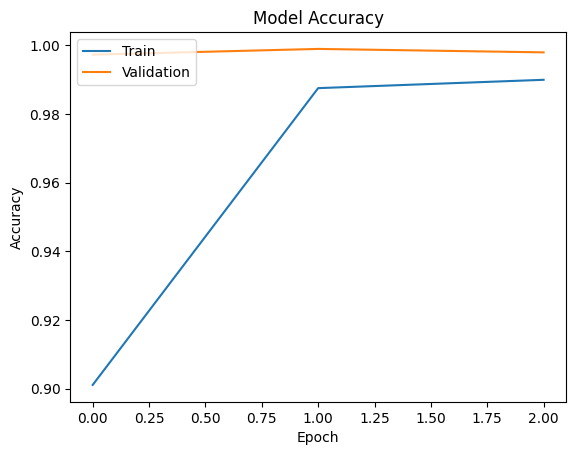

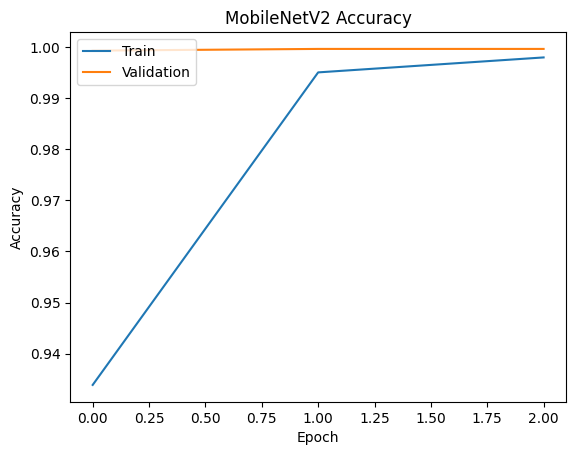

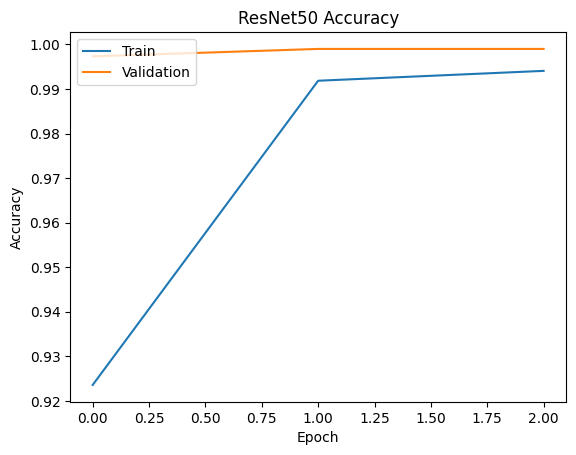

In [25]:
# # Huấn luyện mô hình (ví dụ)
# history = custom_cnn.fit(train_generator_custom, epochs=10, validation_data=val_generator_custom)

# Vẽ biểu đồ độ chính xác của mô hình
plt.plot(history_custom.history['accuracy'])
plt.plot(history_custom.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# # Huấn luyện mô hình MobileNetV2
# history_mobilenet = mobilenet_model.fit(train_generator_mobilenet, epochs=10, validation_data=val_generator_mobilenet)

# # Huấn luyện mô hình ResNet50
# history_resnet = resnet_model.fit(train_generator_resnet, epochs=10, validation_data=val_generator_resnet)

# Vẽ biểu đồ độ chính xác của mô hình MobileNetV2
plt.plot(history_mobilenet.history['accuracy'])
plt.plot(history_mobilenet.history['val_accuracy'])
plt.title('MobileNetV2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Vẽ biểu đồ độ chính xác của mô hình ResNet50
plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])
plt.title('ResNet50 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

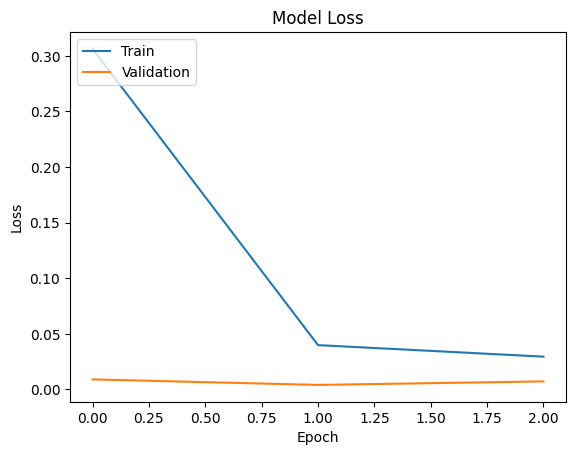

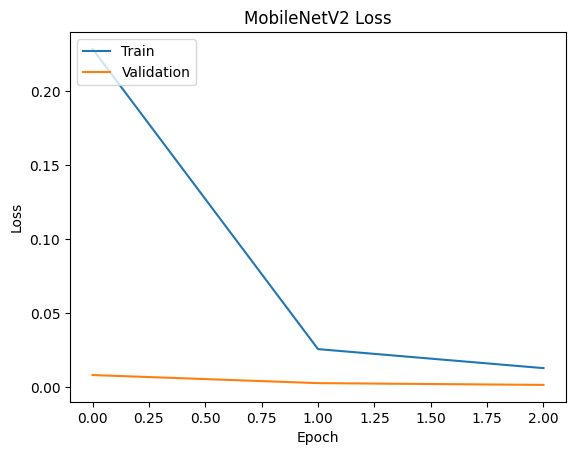

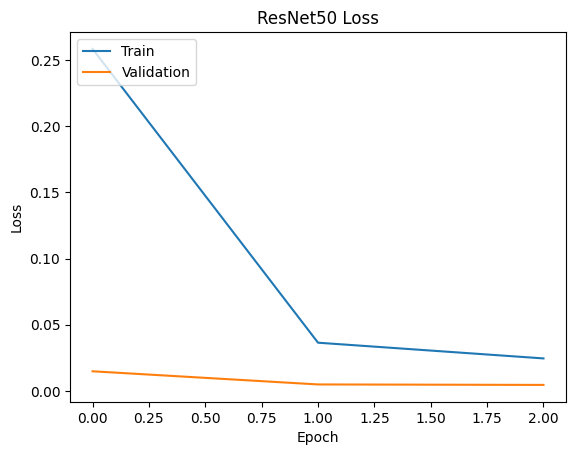

In [29]:
# Vẽ biểu đồ tổn thất của mô hình
plt.plot(history_custom.history['loss'])
plt.plot(history_custom.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Vẽ biểu đồ tổn thất của mô hình MobileNetV2
plt.plot(history_mobilenet.history['loss'])
plt.plot(history_mobilenet.history['val_loss'])
plt.title('MobileNetV2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Vẽ biểu đồ tổn thất của mô hình ResNet50
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])
plt.title('ResNet50 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# # Giả sử test_df là tập dữ liệu kiểm tra và chứa cột 'labels' với các nhãn thực tế
# y_test = test_df['labels'].values

# # Dự đoán trên tập kiểm tra
# pred = best_model.predict(test_generator_custom)
# pred = np.argmax(pred, axis=1)

# # Lấy nhãn từ tập huấn luyện
# labels = (train_generator_custom.class_indices)
# labels = dict((v,k) for k,v in labels.items())
# pred2 = [labels[k] for k in pred]

# # In báo cáo phân loại
# print(classification_report(y_test, pred2))
# print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

# class_labels = ['Palm', 'l', 'Fist', 'Fist_moved', 'Thumb', 'Index', 'Ok', 'Palm_moved', 'C', 'Down']

# cm = confusion_matrix(y_test, pred2)

# plt.figure(figsize=(10, 5))
# sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

# plt.xticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], labels=class_labels, rotation=25)
# plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5], labels=class_labels, rotation=0)
# plt.xlabel("Predicted")
# plt.ylabel("Actual")

# plt.title("Confusion Matrix")

# plt.show()